In [5]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import statsmodels.api as sm
import scipy.optimize as scopt
import os
%matplotlib inline

In [38]:
#load data
stocks = pd.read_csv(os.path.join('data','stocks.csv'))

stock_list = stocks['Symbols'].tolist()
print(stock_list)

num_stocks = len(stock_list)-1


data = pd.DataFrame()
for i in stock_list:
    filename=i+'.csv'
    df = pd.read_csv(os.path.join('data',filename))
    price = df[['Adj Close','Date']].set_index('Date')
    price.rename(columns={'Adj Close': i}, inplace=True)
    data = pd.concat([data,price], axis=1)
data.pop('^DJI')
print(data.head())
print(data.describe())

['MMM', 'AXP', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DWDP', 'XOM', 'GE', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WMT', 'DIS', 'AAPL', '^DJI']
                  MMM        AXP         BA        CAT        CVX       CSCO  \
Date                                                                           
2007-01-03  59.224041  50.453205  67.945892  44.781055  48.461769  22.910717   
2007-01-04  58.989429  50.085419  68.220215  44.663910  47.990608  23.513851   
2007-01-05  58.588360  49.425079  67.930679  44.092781  48.174992  23.522114   
2007-01-08  58.716984  49.893169  67.770653  44.144039  48.789536  23.654301   
2007-01-09  58.785091  49.575539  67.054344  44.385666  48.229595  23.522114   

                   KO       DWDP        XOM         GE    ...            PFE  \
Date                                                      ...                  
2007-01-03  17.589045  38.117035  55.702538  25.740261    ...   

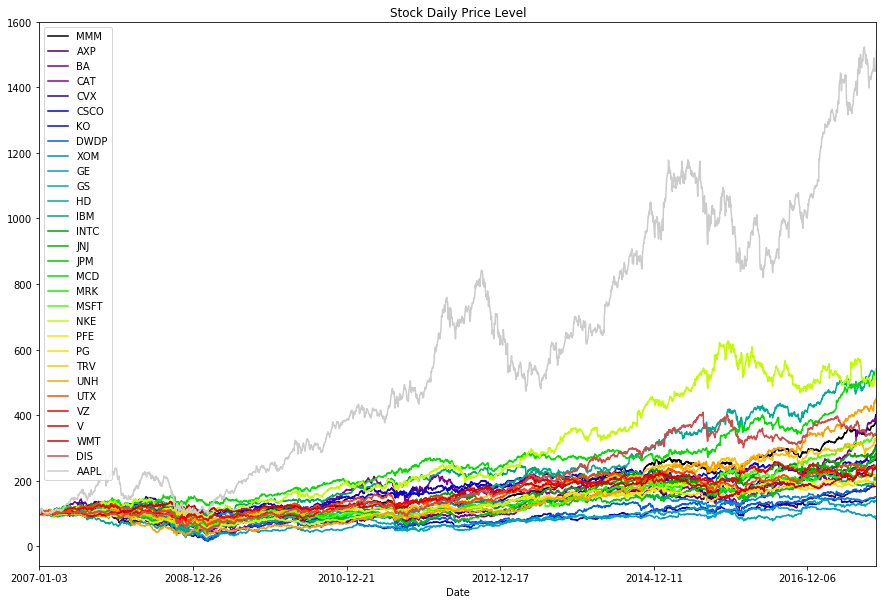

In [34]:
#normalize data to start with 100 level

ndata = (data / data.iloc[0] * 100)
ndata.plot(title="Stock Daily Price Level",cmap='nipy_spectral',figsize=(15, 10))


In [39]:
#we are going to use minimize function to optimize portfolio
def portfolio(weights):
    ''' Parameters 
    weights : array, weights for different stocks
    
    Returns
    p_return : float,  portfolio return
    p_volatility : float,  portfolio volatility
    p_return_to_risk : float, Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    p_return = np.sum(s_returns.mean() * weights) * 252
    p_volatility = np.sqrt(np.dot(weights.T, np.dot(s_returns.cov() * 252, weights)))
    p_return_to_risk = p_return/p_volatility
    return np.array([p_return, p_volatility, p_return_to_risk])

#Minimize loss
def objective(weights):
    return -portfolio(weights)[2]

#constrain,total normalized weights equal to 1
def constrain1(x):
    return ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

#weights are bound to be within 0 and 1.
bnds = tuple((0, 1) for x in range(num_stocks))



In [40]:
#we start with equal weights
weights = np.array(num_stocks * [1. / num_stocks,])
#returen
s_returns = np.log(data / data.shift(1))
# expected portfolio variance
p_volatility=np.dot(weights.T, np.dot(s_returns.cov() * 252, weights))
p_volatility


0.038092412531866862

In [41]:
%%time
p_returns = []
p_volatilities = []
for p in range (2500):
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    p_returns.append(np.sum(s_returns.mean() * weights) * 252)
    p_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(s_returns.cov() * 252, weights))))
p_returns = np.array(p_returns)
p_volatilities = np.array(p_volatilities)

Wall time: 20.7 s


In [45]:
#minimize loss
%%time
solution = scopt.minimize(objective, num_stocks * [1. / num_stocks,], method='SLSQP',bounds=bnds, constraints=cons)

Wall time: 2.34 s


In [46]:
solution

     fun: -1.0290643145468568
     jac: array([  8.15342069e-02,   1.04884355e+00,   2.62802839e-01,
         5.18345878e-01,   5.00159830e-01,   7.98661545e-01,
         5.47640920e-02,   8.63767713e-01,   6.20205373e-01,
         1.14484932e+00,   1.11678855e+00,   6.40160143e-02,
         3.80421475e-01,   4.18219641e-01,   3.45289707e-04,
         9.26153123e-01,   1.49697065e-04,   3.78836751e-01,
         2.77166739e-01,   6.88362420e-02,   3.26796800e-01,
         2.32705593e-01,   3.90755743e-01,   1.42215312e-01,
         4.42973033e-01,   2.14864865e-01,  -1.34710968e-03,
         9.23155397e-02,   3.49669978e-01,   7.31199980e-04])
 message: 'Optimization terminated successfully.'
    nfev: 258
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([  0.00000000e+00,   3.40995259e-16,   0.00000000e+00,
         4.51486173e-16,   0.00000000e+00,   1.65955571e-15,
         0.00000000e+00,   5.14399516e-16,   0.00000000e+00,
         9.82181530e-16,   5.43520123e-16

In [47]:
#get stocks
solution['x'].round(3)


array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.111,  0.   ,
        0.448,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.207,  0.   ,  0.   ,  0.234])

In [30]:
#get resturn, valitility, and sharpe ratio
portfolio(solution['x']).round(3)

array([ 0.188,  0.182,  1.029])

In [48]:
#minimize variance
def objective2(weights):
    return portfolio(weights)[1] ** 2

solution2 = scopt.minimize(objective2, num_stocks * [1. / num_stocks,], method='SLSQP', bounds=bnds,constraints=cons)

solution2['x'].round(3)

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.145,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.048,  0.   ,  0.318,  0.   ,
        0.174,  0.   ,  0.   ,  0.   ,  0.   ,  0.156,  0.   ,  0.   ,
        0.   ,  0.005,  0.   ,  0.154,  0.   ,  0.   ])

In [ ]:
#max portfolio return
cons = ({'type': 'eq', 'fun': lambda x: portfolio(x)[0] - tret},{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

#minimize valitility
def objective3(weights):
    return portfolio(weights)[1]

In [67]:
%%time
tgt_returns = np.linspace(0, 0.3, 5)
tgt_volatilities = []
for tgt_return in tgt_returns:
    cons = ({'type': 'eq', 'fun': lambda x: portfolio(x)[0] - tgt_return},{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = scopt.minimize(objective3, num_stocks * [1. / num_stocks,], method='SLSQP',bounds=bnds, constraints=cons)
    tgt_volatilities.append(res['fun'])
tgt_volatilities = np.array(tgt_volatilities)


Wall time: 59.7 s


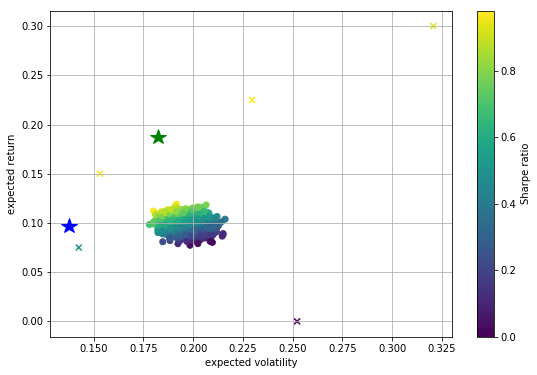

In [69]:
''' the dots----random portfolios; blue star (leftmost)--- minimum risk portfolio;  green star -- max return with min risk'''
plt.figure(figsize=(9, 6))

plt.scatter(p_volatilities, p_returns,c=p_returns/p_volatilities, marker='o')# random portfolio composition
plt.scatter(tgt_volatilities, tgt_returns,c=tgt_returns / tgt_volatilities, marker='x')# efficient frontier
plt.plot(portfolio(solution['x'])[1], portfolio(solution['x'])[0],'g*', markersize=16.0)# portfolio with highest Sharpe ratio
plt.plot(portfolio(solution2['x'])[1], portfolio(solution2['x'])[0],'b*', markersize=16.0)# minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')